# Logistic Regression
### Logistic regression is a supervised learning algorithm tailored for binary classification, predicting the probability of a categorical outcome (e.g., 0 or 1) by modeling the relationship between independent variables (features) and the log-odds of the dependent variable. Unlike linear regression, it employs the logistic (sigmoid) function to transform the linear combination of features into a probability, making it ideal for tasks like predicting Titanic passenger survival based on attributes such as age, class, and sex. It assumes a linear relationship between the log-odds and features, offering interpretability through odds ratios and probabilistic outputs. However, its performance can falter with non-linear boundaries or highly imbalanced datasets. 

### Use Logistic regression as a baseline for classification tasks, iterating with regularization or non-linear models (e.g., SVM, neural networks).

| Aspect            | Details
| :- | :- |
| Use For           | Binary classification (e.g., survival prediction, spam vs. not spam)<br>Can be extended to multiclass with techniques like one-vs-rest |
| Key Assumptions   | - Linear relationship between log-odds and features<br>- Independence of observations<br>- No extreme multicollinearity<br>- Large sample size for reliable estimates |
| Advantages        | - Provides probabilistic outputs for decision-making<br>- Highly interpretable via odds ratios<br>- Efficient for linearly separable data |
| Disadvantages     | - Struggles with non-linear decision boundaries<br>- Sensitive to imbalanced datasets<br>- Assumes linearity in log-odds |
| Avoid When        | - Data exhibits strong non-linear patterns<br>- Severe class imbalance without adjustment<br>- Small sample size with many features |
| Real-World Use Case | Titanic survival prediction (e.g., estimating survival likelihood based on passenger features)<br>Spam detection (e.g., classifying emails as spam or not spam) |

## Problem Description: 
### Predicts whether a passenger survived the Titanic disaster using the Kaggle Titanic dataset, offering insights into historical survival patterns.

Using Kaggle dataset https://www.kaggle.com/c/titanic/data

In [12]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib 
import os

In [13]:
project_dir = './02_logistic_regression'

# load training dataset
data = pd.read_csv(project_dir + '/data/train.csv')

# adding in new features improves accuracy from 0.82 to 0.85
# further improvements can be made by hyperparameter tuning or enemble methods i.e. random forest

# feature engineering  
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1 
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+).', expand=False) 
data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'der', 'Shawah'], 'Rare') 
data['Title'] = data['Title'].replace('Mlle', 'Miss') 
data['Title'] = data['Title'].replace('Ms', 'Miss') 
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
data['AgeCategory'] = pd.cut(data['Age'], bins=[0, 12, 19, 64, np.inf], labels=[0, 1, 2, 3], right=False) 
data['AgeCategory'] = data['AgeCategory'].cat.add_categories(-1).fillna(-1).astype(int) 
data['FarePerPerson'] = data['Fare'] / data['FamilySize'].replace(0, 1) 
data['Deck'] = data['Cabin'].str[0].fillna('U') 
ticket_counts = data['Ticket'].value_counts() 
data['TicketGroupSize'] = data['Ticket'].map(ticket_counts) 
data['EmbarkedMissing'] = data['Embarked'].isna().astype(int)

In [14]:
# select key features
features =  ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Title', 'IsAlone', 'AgeCategory', 'FarePerPerson', 'Deck', 'TicketGroupSize', 'EmbarkedMissing']

X = data[features] 
y = data['Survived']

# define categorical and numerical features
categorical_features = ['Sex', 'Title', 'Deck']  # added additional engineered features 'Title', 'Deck
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'AgeCategory', 'FarePerPerson', 'TicketGroupSize', 'EmbarkedMissing'] # added additional engineered features 'FamilySize', 'IsAlone', 'AgeCategory', 'FarePerPerson', 'TicketGroupSize', 'EmbarkedMissing'

# create a preprocessing pipeline and impute missing values: median for numerical, most frequent for categorical
preprocessor = ColumnTransformer(transformers=[('num', 
                                               Pipeline([('imputer', SimpleImputer(strategy='median')), 
                                                         ('scaler', StandardScaler())]), numerical_features), 
                                                         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)])

# combine preprocessing with the model in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('classifier', LogisticRegression(max_iter=1000, random_state=40))])


param_grid = { 'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear', 'saga']  } # liblinear for l1/l2, saga for flexibility
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X, y) # Fit on full dataset for ensemble training 
best_lr = grid_search.best_estimator_ 
print(f'Best Logistic Regression Params: {grid_search.best_params_}')

/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories

Best Logistic Regression Params: {'classifier__C': 100.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
# split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40,shuffle=True)

lr_pred = best_lr.predict(X_test) 
lr_accuracy = accuracy_score(y_test, lr_pred) 
print(f'Logistic Regression Accuracy: {lr_accuracy:.2f}')


# cross-validation
lr_cv_scores = cross_val_score(best_lr, X, y, cv=5) 
print(f'Logistic Regression CV Accuracy: {lr_cv_scores.mean():.2f} (+/- {lr_cv_scores.std() * 2:.2f})')

Logistic Regression Accuracy: 0.85
Logistic Regression CV Accuracy: 0.83 (+/- 0.05)


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories

In [16]:
# predict and evaluate using the fitted best_lr pipeline
y_pred = best_lr.predict(X_test) 
accuracy = accuracy_score(y_test, y_pred) 
conf_matrix = confusion_matrix(y_test, y_pred) 
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}') 
print('Confusion Matrix:') 
print(conf_matrix) 
print('Classification Report:') 
print(class_report)

Accuracy: 0.85
Confusion Matrix:
[[89 14]
 [13 63]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       103
           1       0.82      0.83      0.82        76

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



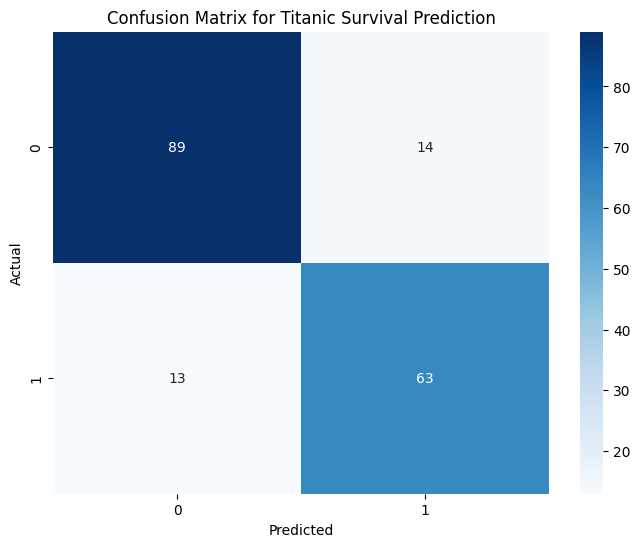

In [17]:
# visualize confusion matrix.
plt.figure(figsize=(8, 6)) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.title('Confusion Matrix for Titanic Survival Prediction') 
plt.show()

In [18]:
# save the trained model2 to a file using joblib for later use
model_dir = project_dir + '/model' 
os.makedirs(model_dir, exist_ok=True) 
model_filename = os.path.join(model_dir, 'titanic_model.pkl') 
joblib.dump(best_lr, model_filename) 
print(f'Model saved as {model_filename}')

Model saved as ./02_logistic_regression/model/titanic_model.pkl


In [19]:
# load the model and run a prediction test on test.csv
loaded_model = joblib.load(model_filename)

In [20]:
# load and preprocess test.csv
test_data = pd.read_csv(project_dir + '/data/test.csv') 
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1 
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+).', expand=False) 
test_data['Title'] = test_data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare') 
test_data['Title'] = test_data['Title'].replace('Mlle', 'Miss') 
test_data['Title'] = test_data['Title'].replace('Ms', 'Miss') 
test_data['Title'] = test_data['Title'].replace('Mme', 'Mrs') 
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int) 
test_data['AgeCategory'] = pd.cut(test_data['Age'], bins=[0, 12, 19, 64, np.inf], labels=[0, 1, 2, 3], right=False) 
test_data['AgeCategory'] = test_data['AgeCategory'].cat.add_categories(-1).fillna(-1).astype(int) 
test_data['FarePerPerson'] = test_data['Fare'] / test_data['FamilySize'].replace(0, 1) 
test_data['Deck'] = test_data['Cabin'].str[0].fillna('U') 
ticket_counts = test_data['Ticket'].value_counts() 
test_data['TicketGroupSize'] = test_data['Ticket'].map(ticket_counts) 
test_data['EmbarkedMissing'] = test_data['Embarked'].isna().astype(int) 
X_test_full = test_data[features]



# predict using the loaded model
test_predictions = loaded_model.predict(X_test_full)

# show predictions for the test set
print("Predictions for test set:")
print(test_predictions)

Predictions for test set:
[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
